In [ ]:
# Jason Qin
# 04/26/21

# Analyzing Classification Data

Classification results from running TAPE on VDJdb TCR-antigen data.

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist, hamming
import scipy.stats
import sklearn.metrics

from tape.datasets import FastaDataset, pad_sequences
from tape.tokenizers import TAPETokenizer

### Analyze Performance of Classification Model on Validation Data

In [168]:
data_file = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_classification_transformer_21-05-04-17-05-03_317740/eval_predictions_050521_010157.txt'
data = pd.read_csv(data_file, sep='\t')

In [169]:
# clean and organize data
column_names = ['input', 'target', 'prediction', 'index']
for col in column_names:
    # remove all non-numeric parts of data
    if type(data[col][0]) != str:
        continue
    data[col] = data[col].str.replace(r'.*\[', '')
    data[col] = data[col].str.replace(r'\].*', '')
    data[col] = data[col].str.replace(r'        ', ',')
    data[col] = data[col].str.strip()
    
    # convert comma-separated string of ints to list of ints
    data[col] = [np.array([float(y.strip('.')) for y in x]) for x in data[col].str.split(',')]

data = data.sort_values('index')

<ipython-input-169-8978dd737fa3>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'.*\[', '')
<ipython-input-169-8978dd737fa3>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\].*', '')


In [170]:
inputs = data['input']
predictions = data['prediction']
targets = data['target']

# round predictions to nearest int
preds_round = np.rint(predictions)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='prediction'>

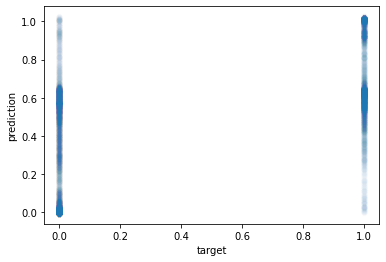

In [172]:
# how do predictions compare to targets?
sns.scatterplot(targets, predictions, alpha=0.01)

In [199]:
# calculate true positives, true negatives, false pos, and false neg
preds_confusion_matrix = sklearn.metrics.confusion_matrix(targets, preds_round)

true_neg = preds_confusion_matrix[0,0]
false_pos = preds_confusion_matrix[0,1]
false_neg = preds_confusion_matrix[1,0]
true_pos = preds_confusion_matrix[1,1]

true_neg_rate = true_neg / (true_neg + false_pos)
false_pos_rate = false_pos / (true_neg + false_pos)
false_neg_rate = false_neg / (true_pos + false_neg)
true_pos_rate = true_pos / (true_pos + false_neg)

In [174]:
print('True Negative Rate: {}'.format(true_neg_rate))
print('False Positive Rate: {}'.format(false_pos_rate))
print('False Negative Rate: {}'.format(false_neg_rate))
print('True Positive Rate: {}'.format(true_pos_rate))

True Negative Rate: 0.8317242547425474
False Positive Rate: 0.16827574525745256
False Negative Rate: 0.1676829268292683
True Positive Rate: 0.8323170731707317


### Analyze uniqueness of CDR3 and antigen sequences in training data

In [70]:
# relevant data files
data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/data/tcr'
cdr3_train_file = data_dir + '/cdr3_train.fasta'
antigen_train_file = data_dir + '/antigen_train.fasta'
cdr3_valid_file = data_dir + '/cdr3_valid.fasta'
antigen_valid_file = data_dir + '/antigen_valid.fasta'

# set up tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# load relevant data
cdr3_train_data_uncleaned = FastaDataset(cdr3_train_file, in_memory=True)
antigen_train_data_uncleaned = FastaDataset(antigen_train_file, in_memory=True)

In [73]:
# organize data
cdr3_train_data = [tuple(tokenizer.encode(x['primary'])) for x in cdr3_train_data_uncleaned]
antigen_train_data = [tuple(tokenizer.encode(x['primary'])) for x in antigen_train_data_uncleaned]

In [79]:
# find how many times each CDR3 sequence appears in the training data
cdr3_train_counts = {}
for cdr3 in cdr3_train_data:
    if cdr3 not in cdr3_train_counts.keys():
        cdr3_train_counts[cdr3] = 1
    else:
        cdr3_train_counts[cdr3] += 1
        
# find how many times each antigen sequence appears in the training data
antigen_train_counts = {}
for antigen in antigen_train_data:
    if antigen not in antigen_train_counts.keys():
        antigen_train_counts[antigen] = 1
    else:
        antigen_train_counts[antigen] += 1

In [94]:
# find frequency of how many sequences are unique vs. duplicates
cdr3_train_unique_freq = []         # number of sequences with each copy #
cdr3_train_weighted_freq = []       # num of seq with each copy #, weighted by copy #
for key, item in cdr3_train_counts.items():
    cdr3_train_unique_freq += [item]
    cdr3_train_weighted_freq += item*[item]

antigen_train_unique_freq = []
antigen_train_weighted_freq = []
for key, item in antigen_train_counts.items():
    antigen_train_unique_freq += [item]
    antigen_train_weighted_freq += item*[item]

In [104]:
# table of CDR3 sequence frequency in training data
pd.value_counts(cdr3_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,...,92,95,102,117,124,127,138,142,145,323
0,45931,4636,1162,489,236,125,91,70,37,45,...,2,1,1,1,1,1,1,1,1,1


<AxesSubplot:ylabel='Density'>

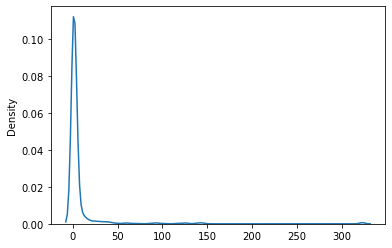

In [95]:
# density plot of CDR3 sequence frequency in training data
# density is weighted by how much each sequence appears in training data
sns.kdeplot(cdr3_train_weighted_freq)

In [107]:
# table of antigen sequence frequency in training data
pd.value_counts(antigen_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,...,871,1211,1355,1507,2414,2449,3171,6527,8810,25160
0,45,96,15,18,4,6,9,5,3,5,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:ylabel='Density'>

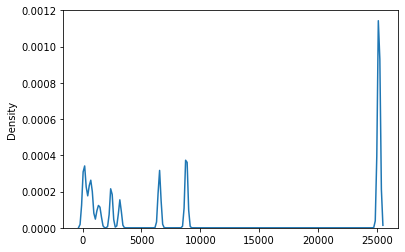

In [105]:
# density plot of CDR3 sequence frequency in training data
# density is weighted by how much each sequence appears in training data
sns.kdeplot(antigen_train_weighted_freq, bw_adjust=0.1)

### Compare validation classification accuracy to frequency of appearance in training data

In [175]:
# create dictionaries that map all unique CDR3 and antigen sequences
# to their targets and predictions of classification
cdr3_valid_preds = {}
cdr3_valid_targets = {}
antigen_valid_preds = {}
antigen_valid_targets = {}

for inp, tar, pred in zip(inputs, targets, preds_round):
    sep = np.where(inp == 3)[0]
    cdr3_sep = sep[0]      # where does CDR3 seq end and antigen begin?
    antigen_sep = sep[1]   # where does antigen seq end and padding begin?
    cdr3 = tuple(inp[:cdr3_sep+1])
    antigen = tuple(np.concatenate(([2], inp[cdr3_sep+1:antigen_sep+1])))   # truncate to only antigen
    if cdr3 not in cdr3_valid_preds.keys():
        cdr3_valid_preds[cdr3] = [pred]
        cdr3_valid_targets[cdr3] = [tar]
    else:
        cdr3_valid_preds[cdr3] += [pred]
        cdr3_valid_targets[cdr3] += [tar]
        
    if antigen not in antigen_valid_preds.keys():
        antigen_valid_preds[antigen] = [pred]
        antigen_valid_targets[antigen] = [tar]
    else:
        antigen_valid_preds[antigen] += [pred]
        antigen_valid_targets[antigen] += [tar]

In [176]:
# find accuracy of model performance on each CDR3 sequence
cdr3_valid_accuracy = {}
for cdr3 in cdr3_valid_preds.keys():
    pred = cdr3_valid_preds[cdr3]
    tar = cdr3_valid_targets[cdr3]
    matches = np.sum(np.logical_xor(pred, tar))
    accuracy = matches / float(len(pred))
    cdr3_valid_accuracy[cdr3] = accuracy

antigen_valid_accuracy = {}
for antigen in antigen_valid_preds.keys():
    pred = antigen_valid_preds[antigen]
    tar = antigen_valid_targets[antigen]
    matches = np.sum(np.logical_xor(pred, tar))
    accuracy = matches / float(len(pred))
    antigen_valid_accuracy[antigen] = accuracy

In [177]:
cdr3_valid_accuracy_list = []
cdr3_valid_freq_in_train = []
for cdr3 in cdr3_valid_accuracy.keys():
    cdr3_valid_accuracy_list += [cdr3_valid_accuracy[cdr3]]
    if cdr3 not in cdr3_train_counts.keys():
        cdr3_valid_freq_in_train += [0]
    else:
        cdr3_valid_freq_in_train += [cdr3_train_counts[cdr3]]
        
antigen_valid_accuracy_list = []
antigen_valid_freq_in_train = []
for antigen in antigen_valid_accuracy.keys():
    antigen_valid_accuracy_list += [antigen_valid_accuracy[antigen]]
    if antigen not in antigen_train_counts.keys():
        antigen_valid_freq_in_train += [0]
    else:
        antigen_valid_freq_in_train += [antigen_train_counts[antigen]]
        
cdr3_valid_accuracy_list = np.array(cdr3_valid_accuracy_list)
cdr3_valid_freq_in_train = np.array(cdr3_valid_freq_in_train)
antigen_valid_accuracy_list = np.array(antigen_valid_accuracy_list)
antigen_valid_freq_in_train = np.array(antigen_valid_freq_in_train)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

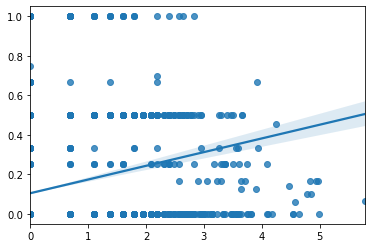

In [178]:
sns.regplot(np.log(cdr3_valid_freq_in_train+1), cdr3_valid_accuracy_list)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

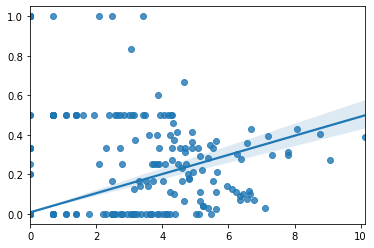

In [179]:
sns.regplot(np.log(antigen_valid_freq_in_train+1), antigen_valid_accuracy_list)

### Compare model performance across different classes of synthetic data

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

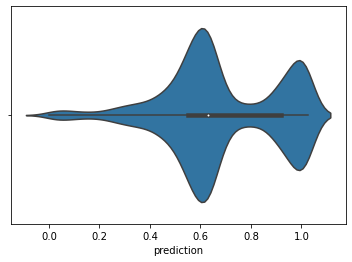

In [197]:
sns.violinplot(predictions[:3936])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

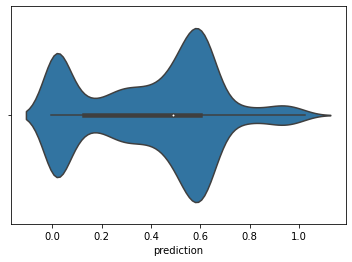

In [194]:
sns.violinplot(predictions[3936:7872])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

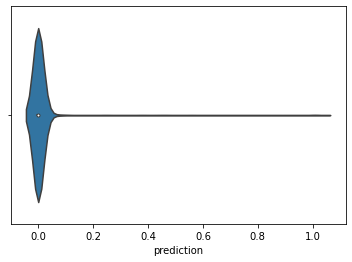

In [195]:
sns.violinplot(predictions[7872:11808])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

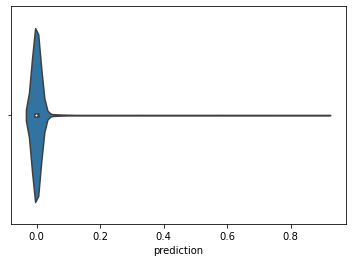

In [196]:
sns.violinplot(predictions[11808:])

In [203]:
# find confusion matrix of positive and permuted negative data
preds_subset_confusion_matrix = sklearn.metrics.confusion_matrix(targets[:7872], preds_round[:7872])

true_neg_subset = preds_subset_confusion_matrix[0,0]
false_pos_subset = preds_subset_confusion_matrix[0,1]
false_neg_subset = preds_subset_confusion_matrix[1,0]
true_pos_subset = preds_subset_confusion_matrix[1,1]

true_neg_subset_rate = true_neg_subset / (true_neg_subset + false_pos_subset)
false_pos_subset_rate = false_pos_subset / (true_neg_subset + false_pos_subset)
false_neg_subset_rate = false_neg_subset / (true_pos_subset + false_neg_subset)
true_pos_subset_rate = true_pos_subset / (true_pos_subset + false_neg_subset)

In [204]:
print('True Negative Subset Rate: {}'.format(true_neg_subset_rate))
print('False Positive Subset Rate: {}'.format(false_pos_subset_rate))
print('False Negative Subset Rate: {}'.format(false_neg_subset_rate))
print('True Positive Subset Rate: {}'.format(true_pos_subset_rate))

True Negative Subset Rate: 0.5180386178861789
False Positive Subset Rate: 0.4819613821138211
False Negative Subset Rate: 0.1676829268292683
True Positive Subset Rate: 0.8323170731707317


In [4]:
antigens = data['antigen']
predictions = data['prediction']

In [5]:
# reduce length of predictions to be closest to each antigen
# this lets us find the closest match between the targets and the
# generated predictions
truncated_predictions = []
for antigen, pred in zip(antigens, predictions):
    stop_idx = np.where(antigen == 3)[0][0]
    if antigen.shape[0] < pred.shape[0]:
        pred[stop_idx] = 3
        pred = pred[0:(stop_idx+1)]
    truncated_predictions += [pred]

In [26]:
# compare truncated predictions to the known targets
truncated_differences = []
for antigen, pred in zip(antigens, truncated_predictions):
    antigen = np.expand_dims(antigen, 0)
    pred = np.expand_dims(pred, 0)
    truncated_differences += [cdist(antigen, pred, metric='hamming').squeeze()]

In [28]:
# truncated predictions and Hamming distance scores of truncated predictions
# to data frame
data['truncated_prediction'] = truncated_predictions
data['truncated_difference'] = truncated_differences

In [45]:
# find all sequences that were perfectly predicted
perf_preds = data[data['truncated_difference'] == 0]['truncated_prediction']

In [46]:
print('Number of total sequences with predictions: {}'.format(data.shape[0]))
print('Number of perfect predictions (after truncation): {}'.format(len(perf_preds)))

Number of total sequences predicted: 1174
Number of perfect predictions (after truncation): 239


In [3]:
# how many of the unique sequences are there in those that were 
# perfectly predicted?
unique_perf_preds = [list(y) for y in set(tuple(x) for x in perf_preds)]

NameError: name 'perf_preds' is not defined

In [49]:
print('Among perfect predictions, number of unique sequences: {}'.format(len(unique_perf_preds)))

Among perfect predictions, number of unique sequences: 30


In [59]:
# how many times does each of the 30 unique sequences get generated?
unique_pred_counts = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in perf_preds]
    unique_pred_counts += [sum(pred_match)]

(array([25.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  9.3, 17.6, 25.9, 34.2, 42.5, 50.8, 59.1, 67.4, 75.7, 84. ]),
 <BarContainer object of 10 artists>)

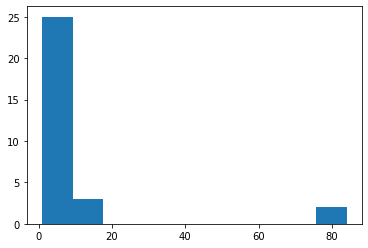

In [63]:
plt.hist(unique_pred_counts)

### Compare Training Data to Validation Data

In [2]:
# find number of times each unique perfect (truncated) prediction 
# can be found in training data
unique_pred_counts_in_train = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in antigen_train_data]
    unique_pred_counts_in_train += [sum(pred_match)]

NameError: name 'unique_perf_preds' is not defined

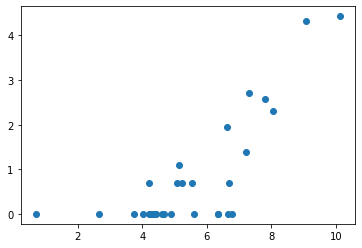

In [90]:
plt.scatter(np.log(unique_pred_counts_in_train), np.log(unique_pred_counts))

In [ ]:
# what is correlation between Hamming distance and number of same
# antigens seen in training data?
all_pred_counts_in_train = []
for pred in truncated_predictions:
    print(pred)
    pred_match = [list(x) == list(pred) for x in antigen_train_data]
    all_pred_counts_in_train += [sum(pred_match)]

[ 2 17 15 22  5 19 25 13 23 19  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 11 19 11 12  9  5 21 10 19  3]
[ 2 14 15 25  5 15 11 13 17  5 25  3]
[ 2 17  9 11 25  5  5 10 21 14  3]
[ 2 11 16 10 17 16 15 22 23 25  3]
[ 2 14 15 22  5 16 15 20  5 16  3]
[ 2 23 23 21  9 22 15 17 19  3]
[ 2 14 15 25  5 15 11 13 17  5 25  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 28 15 20 19 20 23 20 19 15  3]
[ 2 11 23 22 11 22 19 13 25 17 21  3]
[ 2 14 15 11 25  5 15  8  5 22  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 11 19  9 19 15 19 20  5 23  3]
[ 2 15 22 28 26 17 20 16 23  5  9 20  5 23  3]
[ 2 11 15 17 14 13 25 21 16 28 21  3]
[ 2  9 19 15 19 20 11 20 15 23  5  3]
[ 2 11  5  8 21 10 20 21 23 15  3]
[ 2 17  9 22 25  9  5  5 17  3]
[ 2  9  5  5 11 13 11 15  8 19 25  3]
[ 2 14 15 22  5 16 15 20  5 16  3]
[ 2 21 15 21 21 19 25  5 19 25  3]
[ 2 23 19 21 25 23  7 17 17  7 

In [1]:
all_pred_counts_in_train

NameError: name 'all_pred_counts_in_train' is not defined